## ML Model using CNN and LSTM
import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

load data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List of CSV files to use for training
csv_files = ['/content/drive/MyDrive/open_test.csv']  # Add more file names as needed

# Load and concatenate data from multiple CSV files
data_list = []
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    data_list.append(data)

# Concatenate data from all CSV files
data = pd.concat(data_list, ignore_index=True)

In [ ]:
data

,timestamp,Washer,BlowerGH,Lights,BlowerBed,CompGH,CompBed,Dryer,Recs1,Recs2,WaterHeat,Main,Other
0,2023-04-21 05:47:00,0.4,8.1,25.5,1.8,21.7,6.6,0.0,7.3,5.0,0.0,246.5,170.1
1,2023-04-21 05:48:00,0.4,8.0,25.6,1.7,21.8,6.6,0.0,7.3,5.0,0.0,246.6,170.2
2,2023-04-21 05:49:00,0.5,8.0,25.4,1.7,21.7,6.6,0.0,7.2,5.0,0.0,246.5,170.4
3,2023-04-21 05:50:00,0.5,8.0,25.5,1.7,21.8,6.6,0.0,7.3,5.0,0.0,246.6,170.2
4,2023-04-21 05:51:00,0.4,8.0,25.5,1.7,21.7,6.6,0.0,7.3,5.0,0.0,246.4,170.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-04-21 23:56:00,0.5,8.3,25.9,1.7,0.1,6.0,0.0,39.1,5.1,0.0,184.8,98.1
996,2023-04-21 23:57:00,0.5,8.3,25.9,1.7,0.0,6.0,0.0,39.1,5.0,0.0,185.1,98.6
997,2023-04-21 23:58:00,0.5,8.3,25.9,1.8,0.1,6.0,0.0,40.3,5.1,0.0,185.3,97.3
998,2023-04-21 23:59:00,0.5,8.1,25.9,1.8,0.0,6.0,0.0,39.3,5.1,0.0,185.3,98.6


preprocess data

In [ ]:
# Preprocess the timestamp column to extract relevant information
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['Hour'] = data['timestamp'].dt.hour
data['DayOfWeek'] = data['timestamp'].dt.dayofweek
data['Month'] = data['timestamp'].dt.month

# Remove negative values for appropriate columns
for column in data.columns:
    if column != 'timestamp':
        data[column] = data[column].clip(lower=0)  # Clip negative values

# Remove rows with null values
data = data.dropna()
data.drop(columns=['Other'], inplace=True)
#this seems to be causing issues with the model for files that have lots of null values

data.rename(columns={'Main': 'Total'}, inplace=True)
data.rename(columns={'WaterHeat': 'WaterHeater'}, inplace=True)
#data.rename(columns={'temperature_2m': 'Temperature'}, inplace=True)

In [ ]:
data

,timestamp,Washer,BlowerGH,Lights,BlowerBed,CompGH,CompBed,Dryer,Recs1,Recs2,WaterHeater,Total,Hour,DayOfWeek,Month
0,2023-04-21 05:47:00,0.4,8.1,25.5,1.8,21.7,6.6,0.0,7.3,5.0,0.0,246.5,5,4,4
1,2023-04-21 05:48:00,0.4,8.0,25.6,1.7,21.8,6.6,0.0,7.3,5.0,0.0,246.6,5,4,4
2,2023-04-21 05:49:00,0.5,8.0,25.4,1.7,21.7,6.6,0.0,7.2,5.0,0.0,246.5,5,4,4
3,2023-04-21 05:50:00,0.5,8.0,25.5,1.7,21.8,6.6,0.0,7.3,5.0,0.0,246.6,5,4,4
4,2023-04-21 05:51:00,0.4,8.0,25.5,1.7,21.7,6.6,0.0,7.3,5.0,0.0,246.4,5,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-04-21 23:56:00,0.5,8.3,25.9,1.7,0.1,6.0,0.0,39.1,5.1,0.0,184.8,23,4,4
996,2023-04-21 23:57:00,0.5,8.3,25.9,1.7,0.0,6.0,0.0,39.1,5.0,0.0,185.1,23,4,4
997,2023-04-21 23:58:00,0.5,8.3,25.9,1.8,0.1,6.0,0.0,40.3,5.1,0.0,185.3,23,4,4
998,2023-04-21 23:59:00,0.5,8.1,25.9,1.8,0.0,6.0,0.0,39.3,5.1,0.0,185.3,23,4,4


define features and targets

In [ ]:
# No scaling
X = data[['Hour', 'DayOfWeek', 'Month', 'Total']].values
y = data[['Washer', 'BlowerGH', 'Lights', 'BlowerBed', 'CompGH', 'CompBed', 'Dryer', 'Recs1', 'Recs2', 'WaterHeater']].values

Create sequences
-create sequences/windows of data for LSTM. Length of TIME_STEPS is used below

In [ ]:
# Function to create sequences
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

# Create sequences
X_seq, y_seq = create_dataset(X, y, TIME_STEPS)

split data 80/20 for training and testing

In [ ]:
# Split data into training and testing
split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)

X_train, y_train = X_seq[:split_index], y_seq[:split_index]
X_test, y_test = X_seq[split_index:], y_seq[split_index:]

define CNN model creation

In [ ]:
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Add convolutional layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # Reshape the data for LSTM
    model.add(tf.keras.layers.Reshape((-1, 64)))  # 64 corresponds to the number of filters in the last Conv1D layer
    # Add LSTM layers
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    # Add dense layers
    model.add(Dense(10))  # This 10 corresponds to the number of output features
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and compile the model
model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 8, 32)             416       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 4, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 reshape_2 (Reshape)         (None, 1, 64)             0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)            

Train & save model

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
50/50 [==============================] - 5s 23ms/step - loss: 25921.7168 - val_loss: 411.4347
Epoch 2/10
50/50 [==============================] - 0s 5ms/step - loss: 25783.4941 - val_loss: 382.8008
Epoch 3/10
50/50 [==============================] - 0s 6ms/step - loss: 25544.1738 - val_loss: 359.4184
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 25342.1562 - val_loss: 346.9078
Epoch 5/10
50/50 [==============================] - 0s 6ms/step - loss: 25186.4238 - val_loss: 342.5369
Epoch 6/10
50/50 [==============================] - 0s 5ms/step - loss: 25063.3945 - val_loss: 342.1025
Epoch 7/10
50/50 [==============================] - 0s 6ms/step - loss: 24955.5234 - val_loss: 344.4742
Epoch 8/10
50/50 [==============================] - 0s 6ms/step - loss: 24857.8418 - val_loss: 349.7582
Epoch 9/10
50/50 [==============================] - 0s 6ms/step - loss: 24768.1523 - val_loss: 355.3654
Epoch 10/10
50/50 [==============================] - 0s 6ms/ste

In [ ]:
#this exports the model to drive
model.save('/content/drive/MyDrive/P50_trained_model_with_weather.keras')

# Testing model predictions

7/7 [==============================] - 2s 3ms/step
       Washer   BlowerGH     Lights  BlowerBed     CompGH   CompBed     Dryer  \
0    1.974384  20.725502  20.592432   1.693653  26.826809  6.191331  0.023826   
1    1.974384  20.725502  20.592432   1.693653  26.826809  6.191331  0.023826   
2    1.974384  20.725502  20.592432   1.693653  26.826809  6.191331  0.023826   
3    1.974384  20.725502  20.592432   1.693653  26.826809  6.191331  0.023826   
4    1.974384  20.725502  20.592432   1.693653  26.826809  6.191331  0.023826   
..        ...        ...        ...        ...        ...       ...       ...   
194  1.974385  20.725517  20.592442   1.693654  26.826820  6.191335  0.023826   
195  1.974385  20.725519  20.592443   1.693654  26.826820  6.191335  0.023826   
196  1.974385  20.725519  20.592443   1.693654  26.826818  6.191335  0.023826   
197  1.974385  20.725521  20.592445   1.693654  26.826820  6.191335  0.023826   
198  1.974385  20.725515  20.592443   1.693653  26.826820 

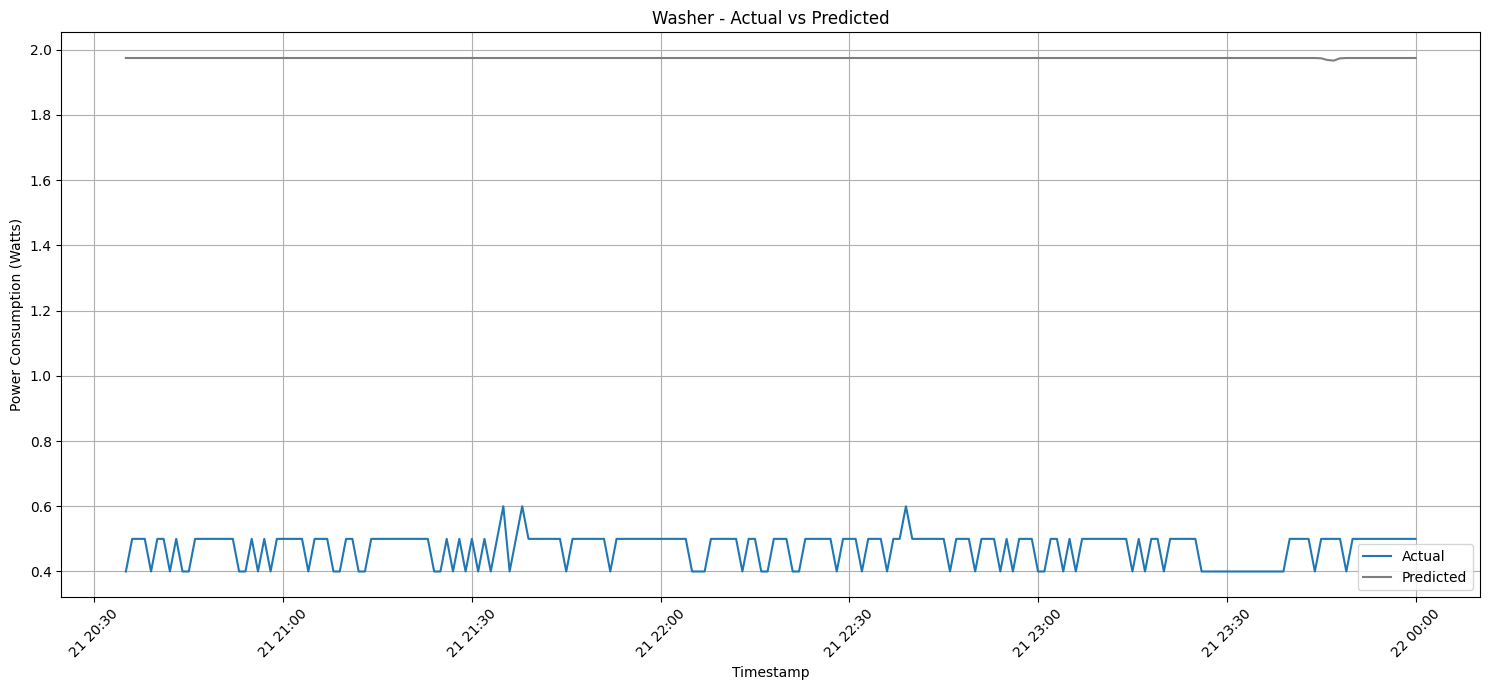

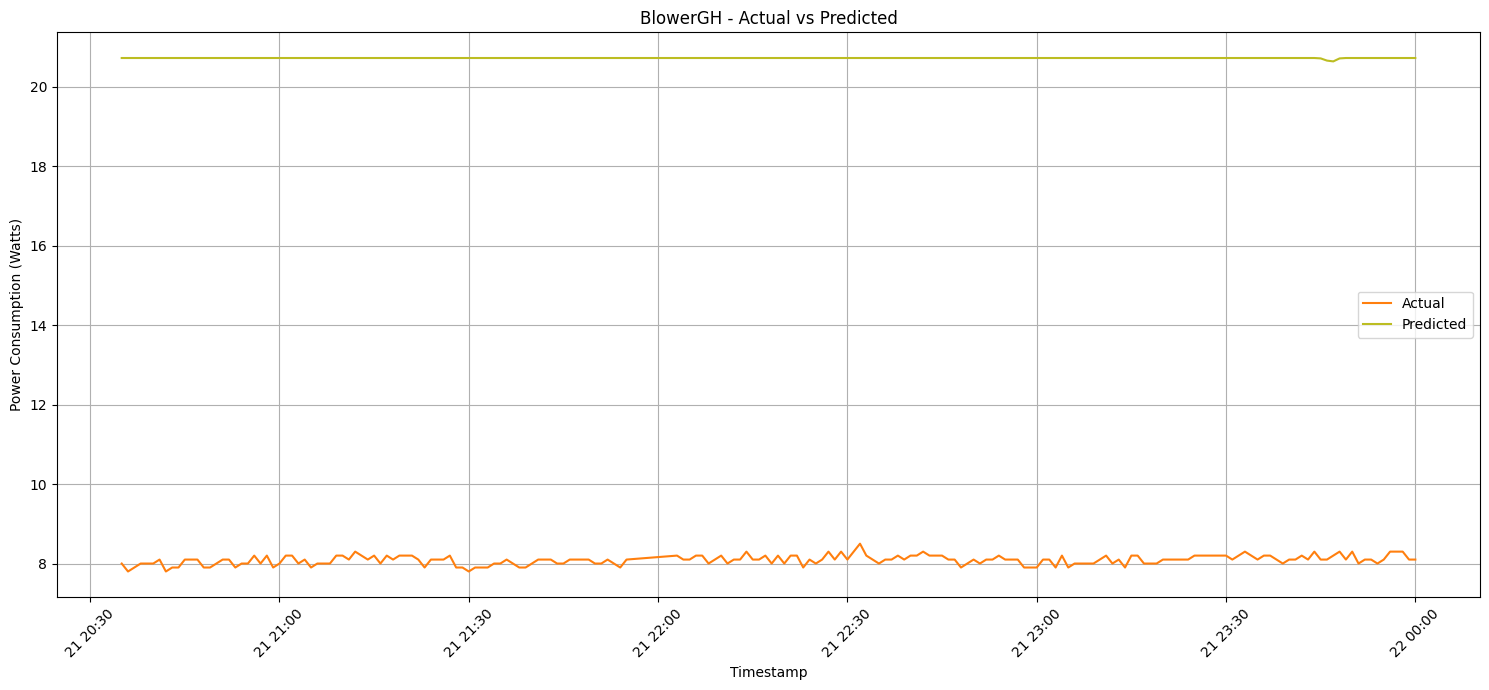

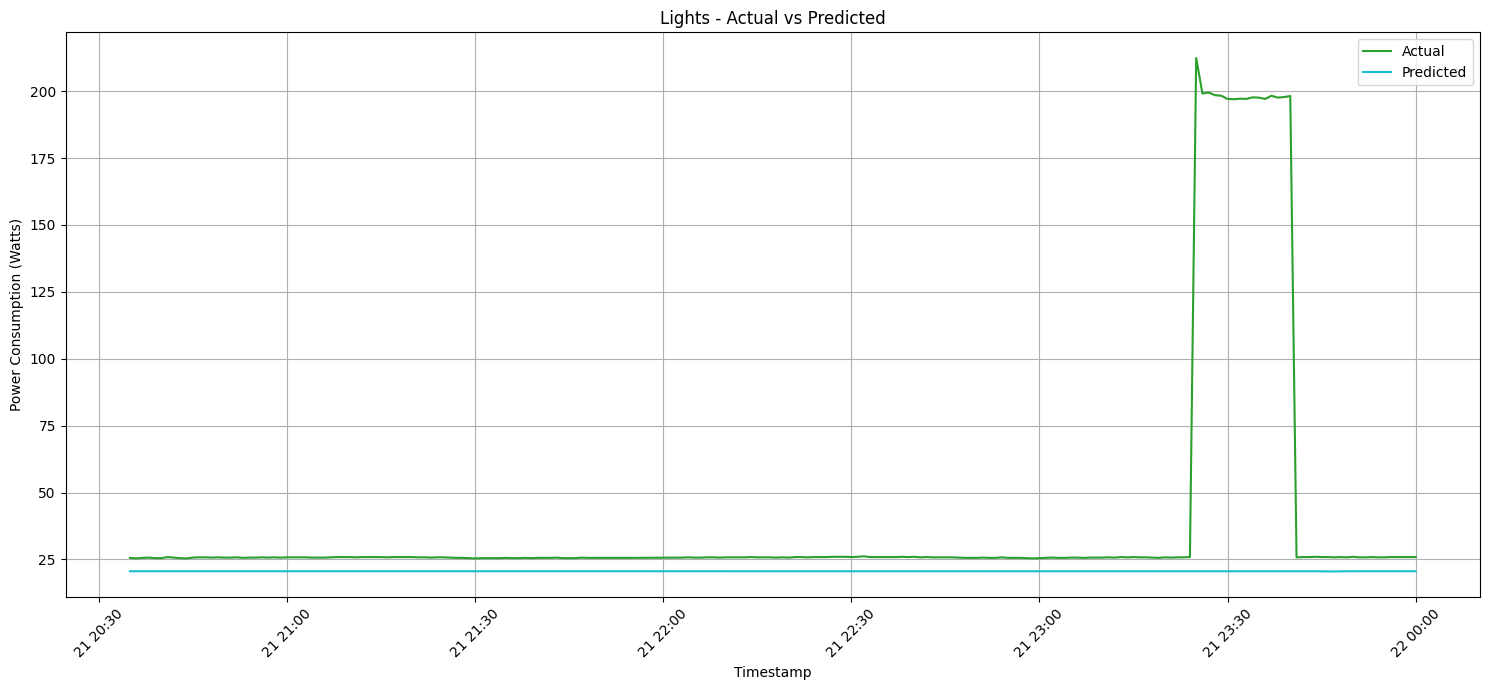

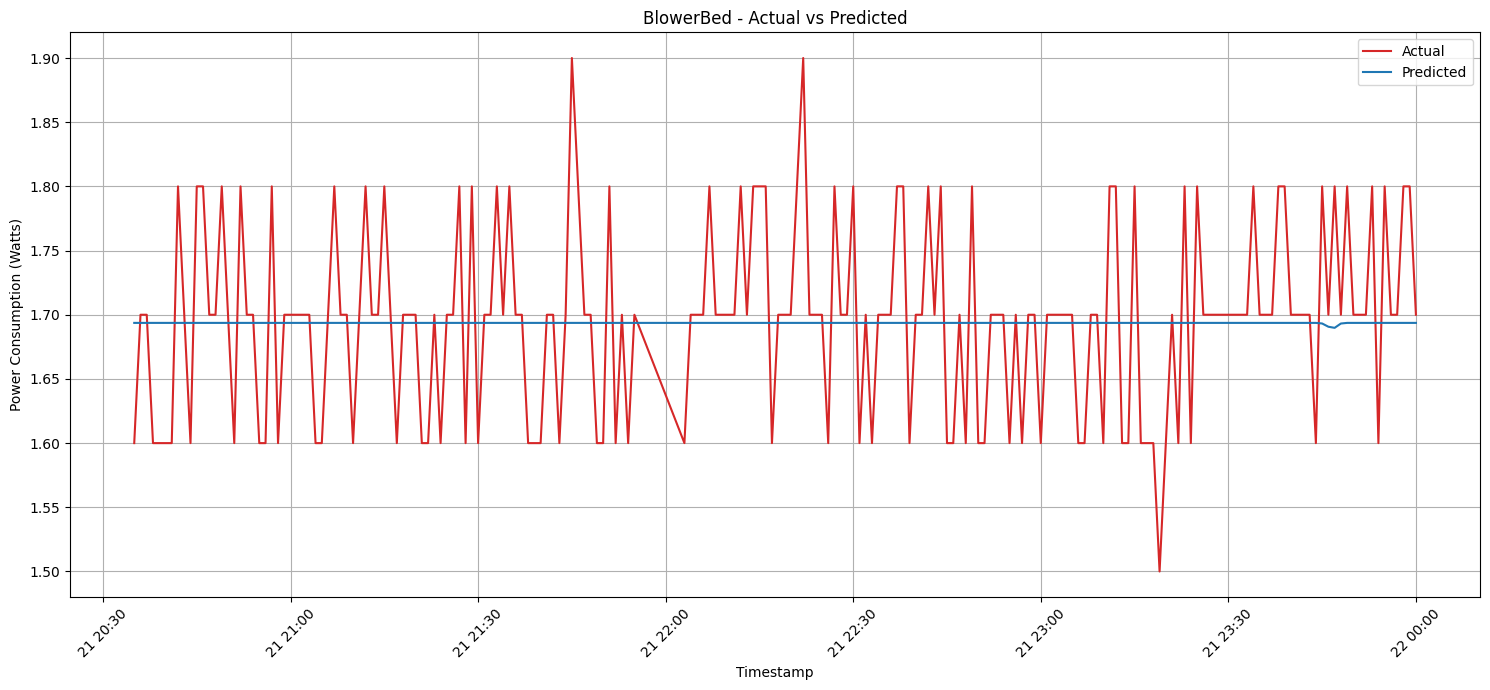

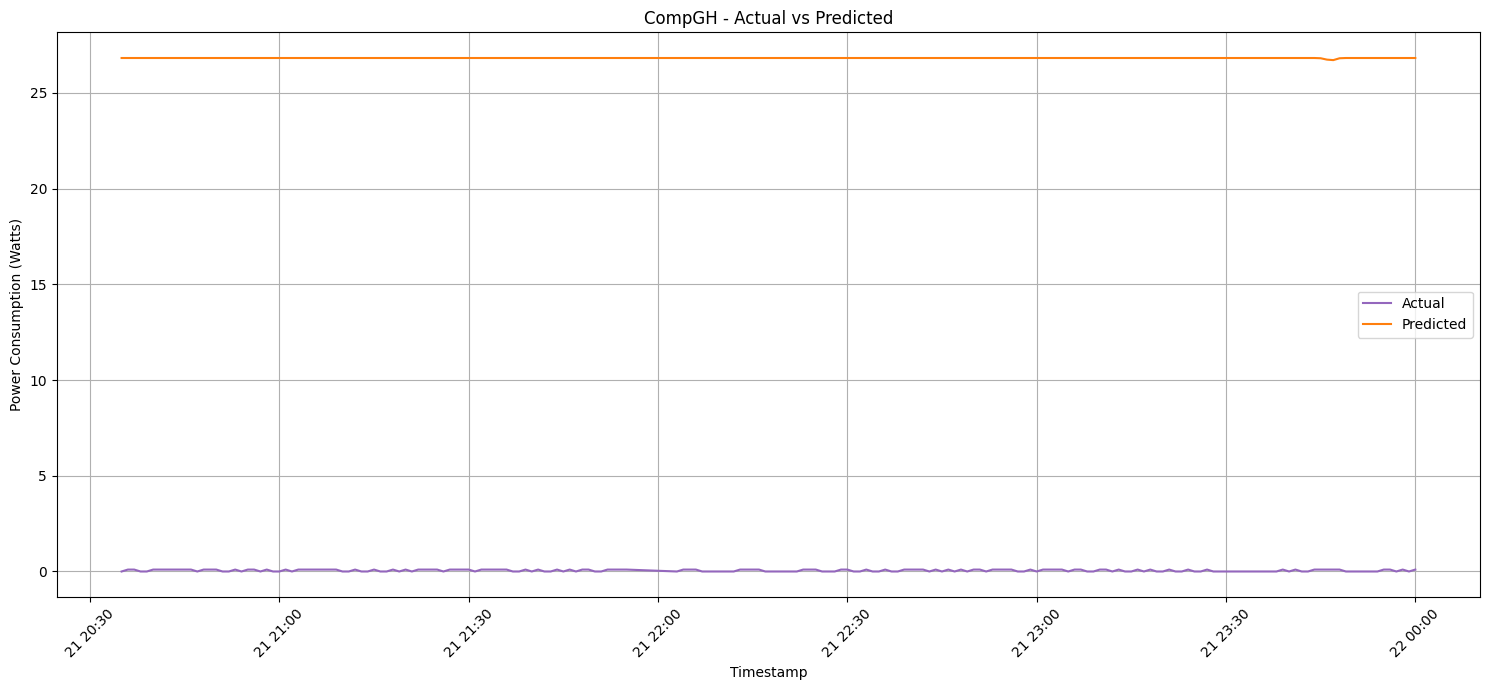

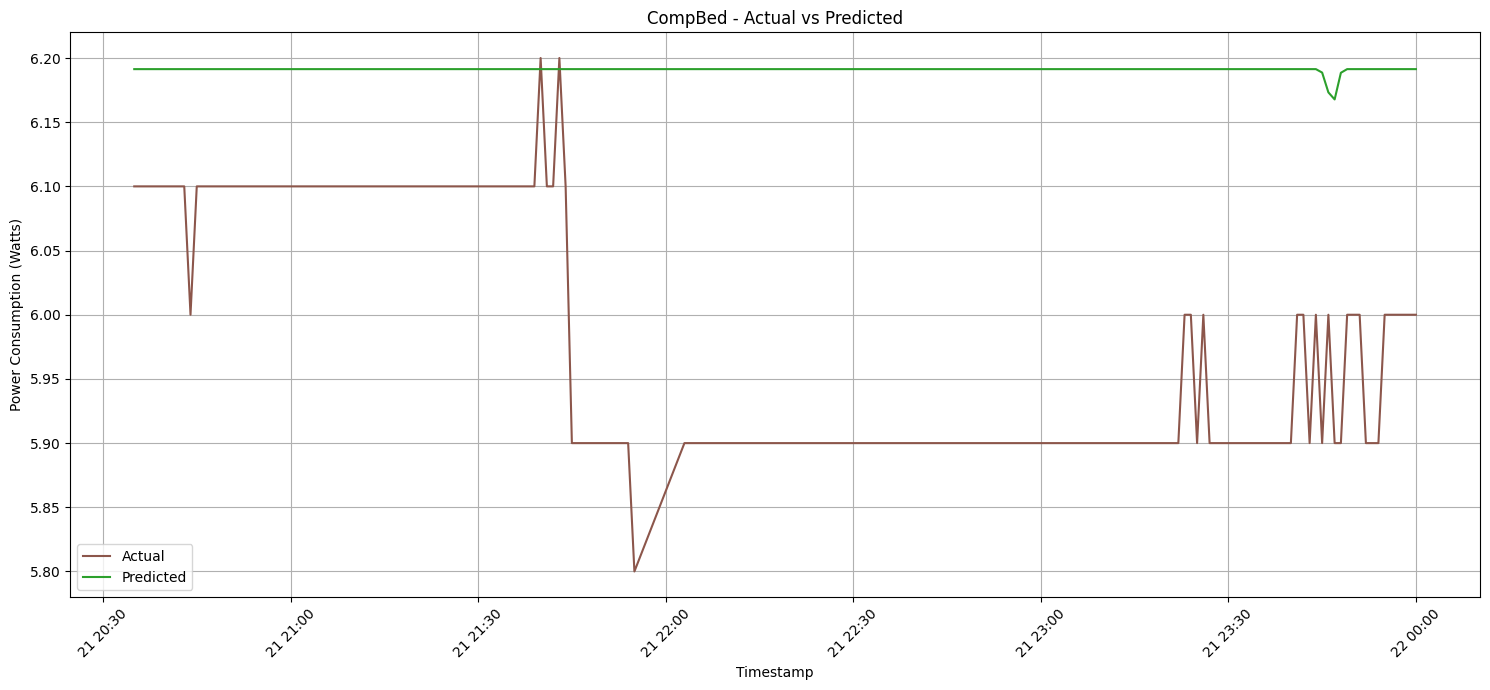

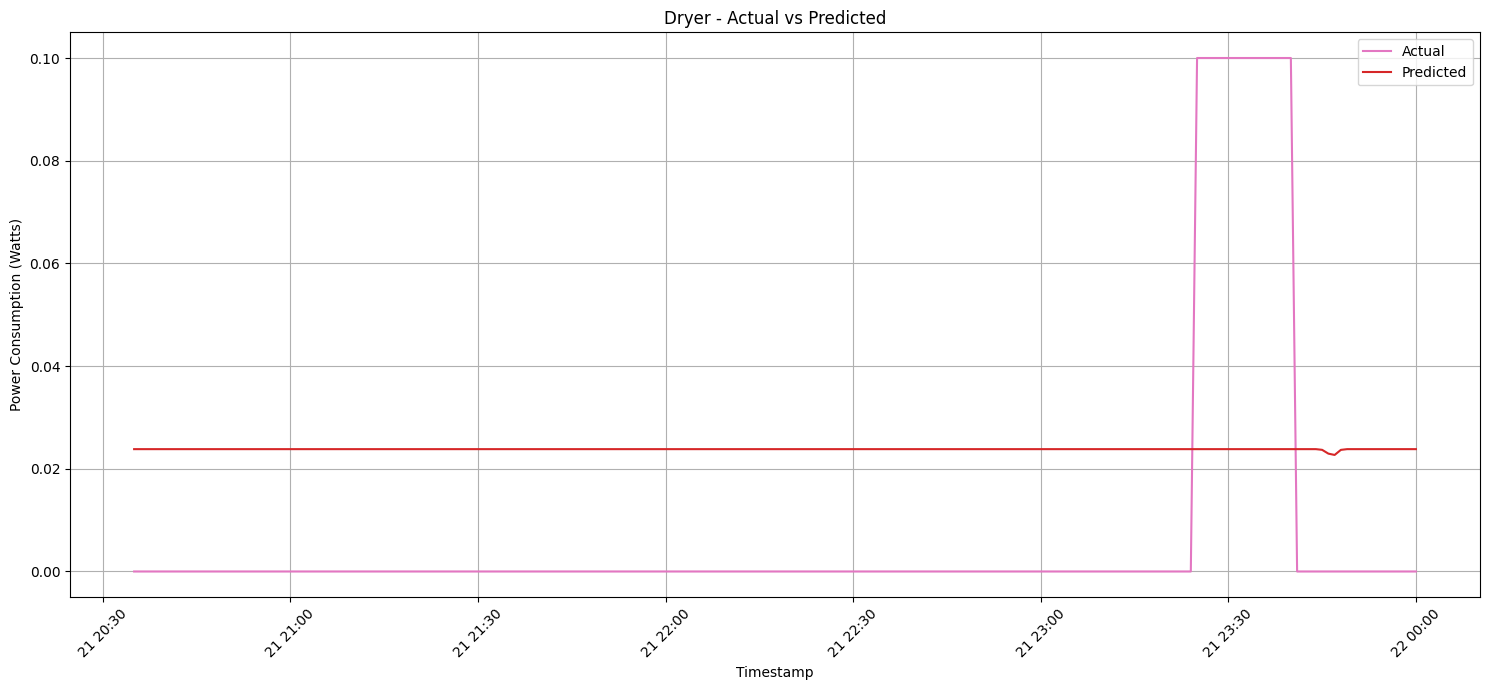

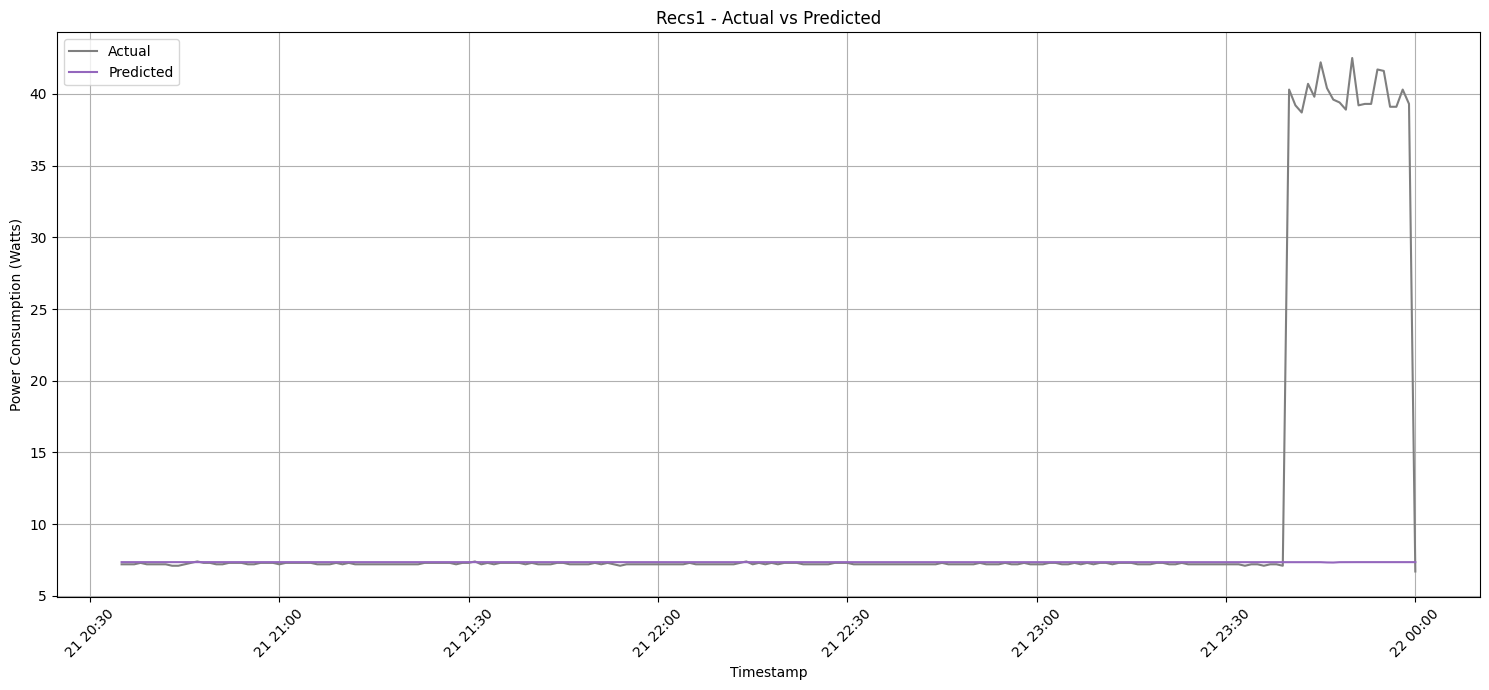

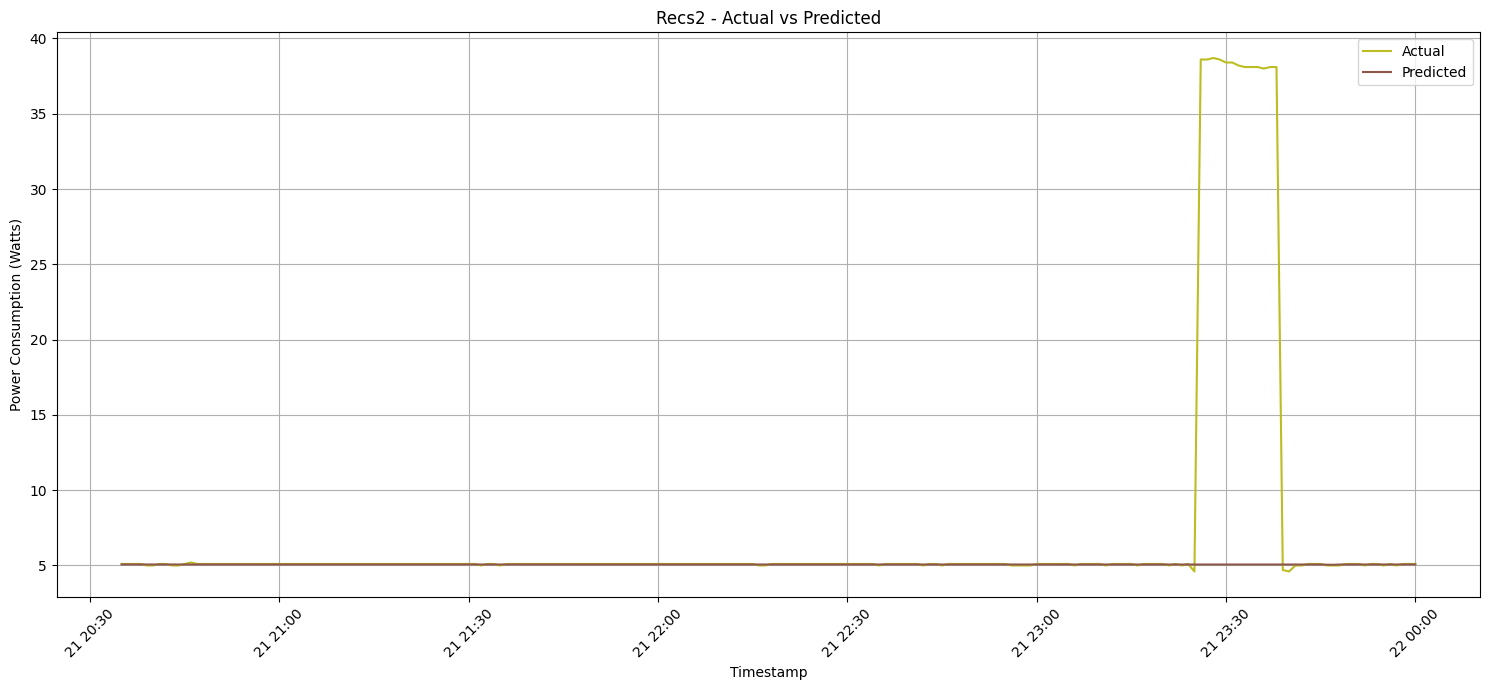

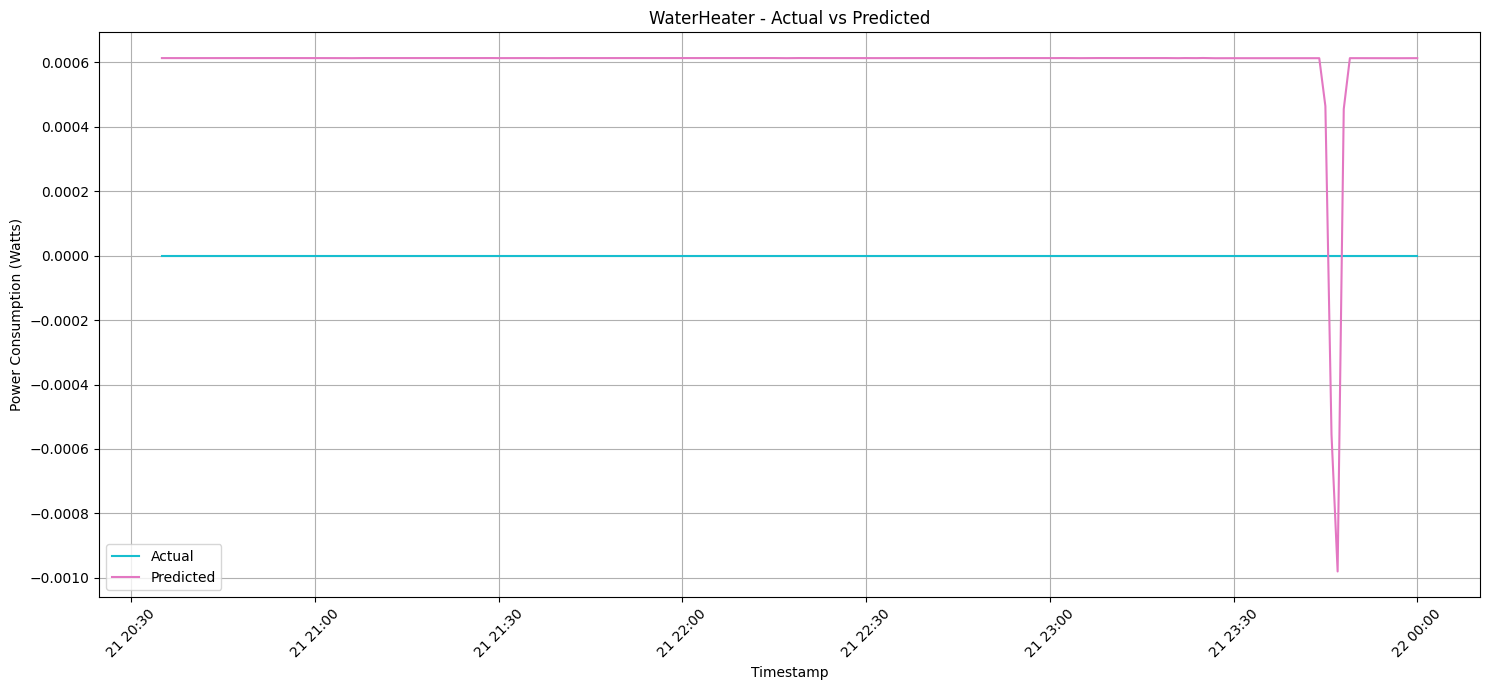

Empty DataFrame
Columns: [Appliance, Actual Total (Watts), Predicted Total (Watts), Percentage Error]
Index: []


In [ ]:
#this makes the actual predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back in Watts instead of normalized
predicted_values = predictions
actual_values = y_test

# Extract timestamps for test
test_timestamps = data['timestamp'].iloc[-len(X_test):]

appliance_names = ['Washer', 'BlowerGH', 'Lights', 'BlowerBed', 'CompGH', 'CompBed', 'Dryer', 'Recs1', 'Recs2', 'WaterHeater']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Appliance', 'Actual Total (Watts)', 'Predicted Total (Watts)', 'Percentage Error'])

# Convert predicted_values array to a DataFrame
predicted_df = pd.DataFrame(predicted_values, columns=appliance_names)

# Print the DataFrame
print(predicted_df)

#this graphs the actual values vs the predicted values for each applicane
for idx, appliance in enumerate(appliance_names):
    plt.figure(figsize=(15, 7))

    # Plot actual usage
    plt.plot(test_timestamps, actual_values[:, idx], label='Actual', color='C'+str(idx))

    # Plot predicted usage
    plt.plot(test_timestamps, predicted_values[:, idx], label='Predicted', color='C'+str(idx+7))

    plt.title(f"{appliance} - Actual vs Predicted")
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (Watts)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

 # Display the results DataFrame
print(results_df)